# Questions for the TA!

1. Do we need to read the data in straight from the web or can we download the data from the web and read it in that way?
2. What does the TA think about analyzing the type of crime too?
3. Does the TA have thoughts on the visualization, any suggestions?
4. What person should this be written in (first person, etc.)
5. What scale parameter makes sense and do we need to include this in our table of estimates?

## Criminality Across Vancouver Neighbourhoods

By: Isabela Lucas Bruxellas, Sam Thorne, Sean Meng

### Introduction

#### Background Information

Despite nation-wide crime rates declining since the 1990s in Canada (STATCAN 2021), many Canadians still fear crime, especially in their local communities (JUSTICE CANADA, 2022). Current research suggests that effective crime control strategies embrace the importance of regular citizens in preventing crime and enhance their ability to do so (USCIDA et al., 2014). This research focuses on empowering citizens by providing understanding of overall and crime specific proportions across the communities of Vancouver. This analysis will infer which districts in Vancouver have proportionally higher and lower crime rates. 



#### Research Question

Is there a difference between the average annual proportion of crimes in Vancouver across different districts? 

To answer this question, we will explore the proportion of crimes grouped per year and across the three districts of the city of Vancouver (Central, East and West). Our goal is to explore this data from a historical perspective, comparing trends across the years 2003 to 2022. We will do so by calculating the mean proportion of crime that lies in each district annually and finding the inter-quartile range. We also intend to analyze trends for the different crime types to explore whether there are significant pattern changes.

#### The Dataset

The dataset used in the analysis is provided by the Vancouver Police Department (VDC) and was collected from the PRIME BC Police Records Management System (RMS). This data reflects all police-reported crimes during the period. The dataset includes information on the type of crime (as aggregations of subset types), time (year, month, day, hour, and minute), and location (general block area and neighbourhood).

### Preliminary Results

In [178]:
set.seed(101)

library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)
library(RColorBrewer)

#### Data import and cleaning

In [179]:
# Reading in data from a downloaded csv file
crimedata <- read_csv('crimedata_csv_AllNeighbourhoods_AllYears.csv')
head(crimedata) 

Rows: 841759 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2012,12,14,8,52,NA,Oakridge,491285.0,5453433
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166


Above is a sample of the data found in this csv file. To answer our question we only require the `YEAR` and `NEIGHBOURHOOD` columns and made sure to remove any rows containing NA values in our columns of interest. We kept the `TYPE` column as well for further analysis. To simplify our analysis we are going to compare crime rates in the four districts of Vancouver instead of neighborhoods. We defined the districts based on the neighborhoods in the data frame and Expat Arrivals. 

In [180]:
# Dropping unnecessary columns and filtering out NA values.
selected_crimedata <- crimedata %>%
    select('YEAR', 'NEIGHBOURHOOD', 'TYPE') %>%
    filter(!is.na(NEIGHBOURHOOD)) %>%
    filter(!is.na(YEAR)) # drop NA values in the neighbourhood column and in the year column. 

# defining the districts of Vancouver. 
central = c('Central Business District', 'Stanley Park', 'West End')
west = c('Fairview', 'Kitsilano', 'West Point Grey',  
        'Shaughnessy', 'Musqueam', 'Arbutus Ridge', 'South Cambie', 'Oakridge')
east = c('Grandview-Woodland', 'Mount Pleasant', 'Kensington-Cedar Cottage',
         'Riley Park', 'Strathcona', 'Hastings-Sunrise', 'Killarney')
south = c('Dunbar-Southlands', 'Kerrisdale', 'Marpole','Sunset', 'Victoria-Fraserview', 
          'Renfrew-Collingwood','Killarney')

# Creating a new column in the data frame of district
# value can be Central, West, East, or South depending on neighbourhood
# Can drop the neighbourhood column here too as from here onwards we will exclusively look at district.
district_crimedata <- selected_crimedata %>%
    mutate(DISTRICT = case_when(
        NEIGHBOURHOOD == 'Central Business District' | NEIGHBOURHOOD == 'Stanley Park' | NEIGHBOURHOOD == 'West End' ~ 'Central',
        NEIGHBOURHOOD == 'Fairview' | NEIGHBOURHOOD == 'Kitsilano'| NEIGHBOURHOOD =='West Point Grey'|
        NEIGHBOURHOOD == 'Shaughnessy'| NEIGHBOURHOOD == 'Musqueam'|
        NEIGHBOURHOOD == 'Arbutus Ridge'| NEIGHBOURHOOD == 'South Cambie' | NEIGHBOURHOOD == 'Oakridge' ~ 'West',
        NEIGHBOURHOOD == 'Grandview-Woodland'| NEIGHBOURHOOD == 'Mount Pleasant'| 
        NEIGHBOURHOOD == 'Kensington-Cedar Cottage'| NEIGHBOURHOOD == 'Riley Park'| NEIGHBOURHOOD == 'Strathcona'|
        NEIGHBOURHOOD == 'Hastings-Sunrise' ~ 'East',
        NEIGHBOURHOOD == 'Dunbar-Southlands'|NEIGHBOURHOOD == 'Kerrisdale' | NEIGHBOURHOOD == 'Marpole'|NEIGHBOURHOOD == 'Sunset'|
        NEIGHBOURHOOD == 'Victoria-Fraserview'|NEIGHBOURHOOD == 'Renfrew-Collingwood'|NEIGHBOURHOOD == 'Killarney'~'South')) %>%
    select(-NEIGHBOURHOOD)
    # filter(is.na(DISTRICT)) # use to make sure every neighbourhood in the data has been included.

# the minimum year in this data is 2003 so this is how far back we will be looking.
print(paste("The first year to be included in our analysis is", min(crimedata$YEAR)))
# 2021 will be the maximum year in our data as 2022 has not finished yet so it's numbers are not
# representative of an entire year of crime.

# removing the year 2022 from the data
year_crime_data <- district_crimedata %>%
    filter(YEAR != 2022)

# Next we grouped the type of crime into more broad categories than what is in the original data set. 
crime_data <- year_crime_data %>%
    mutate(TYPE = case_when(
        TYPE == "Break and Enter Commercial"|TYPE == "Break and Enter Residential/Other" ~ "Break and Enter",
        TYPE == "Other Theft"|TYPE == "Theft from Vehicle"|TYPE == "Theft of Bicycle"|TYPE == "Theft of Vehicle" ~ "Theft",
        TYPE == "Vehicle Collision or Pedestrian Struck (with Fatality)"|TYPE == "Vehicle Collision or Pedestrian Struck (with Injury)"~"Car accident",
        TYPE == 'Homicide' ~ 'Homicide', TYPE == 'Mischief'~'Mischief', TYPE == 'Offence Against a Person'~'Offence Against a Person'))

print("This is a piece of the wrangled data frame")
head(crime_data)

[1] "The first year to be included in our analysis is 2003"
[1] "This is a piece of the wrangled data frame"


YEAR,TYPE,DISTRICT
<dbl>,<chr>,<chr>
2012,Break and Enter,West
2019,Break and Enter,West
2019,Break and Enter,Central
2021,Break and Enter,Central
2014,Break and Enter,Central
2020,Break and Enter,Central


#### Data Plots

We are going to visualize the distribution of the number of crimes committed from the years 2003 - 2021 for all four district in Vancouver. The stacks in the bar graph are also color coded for the type of crime committed for our further analysis. 

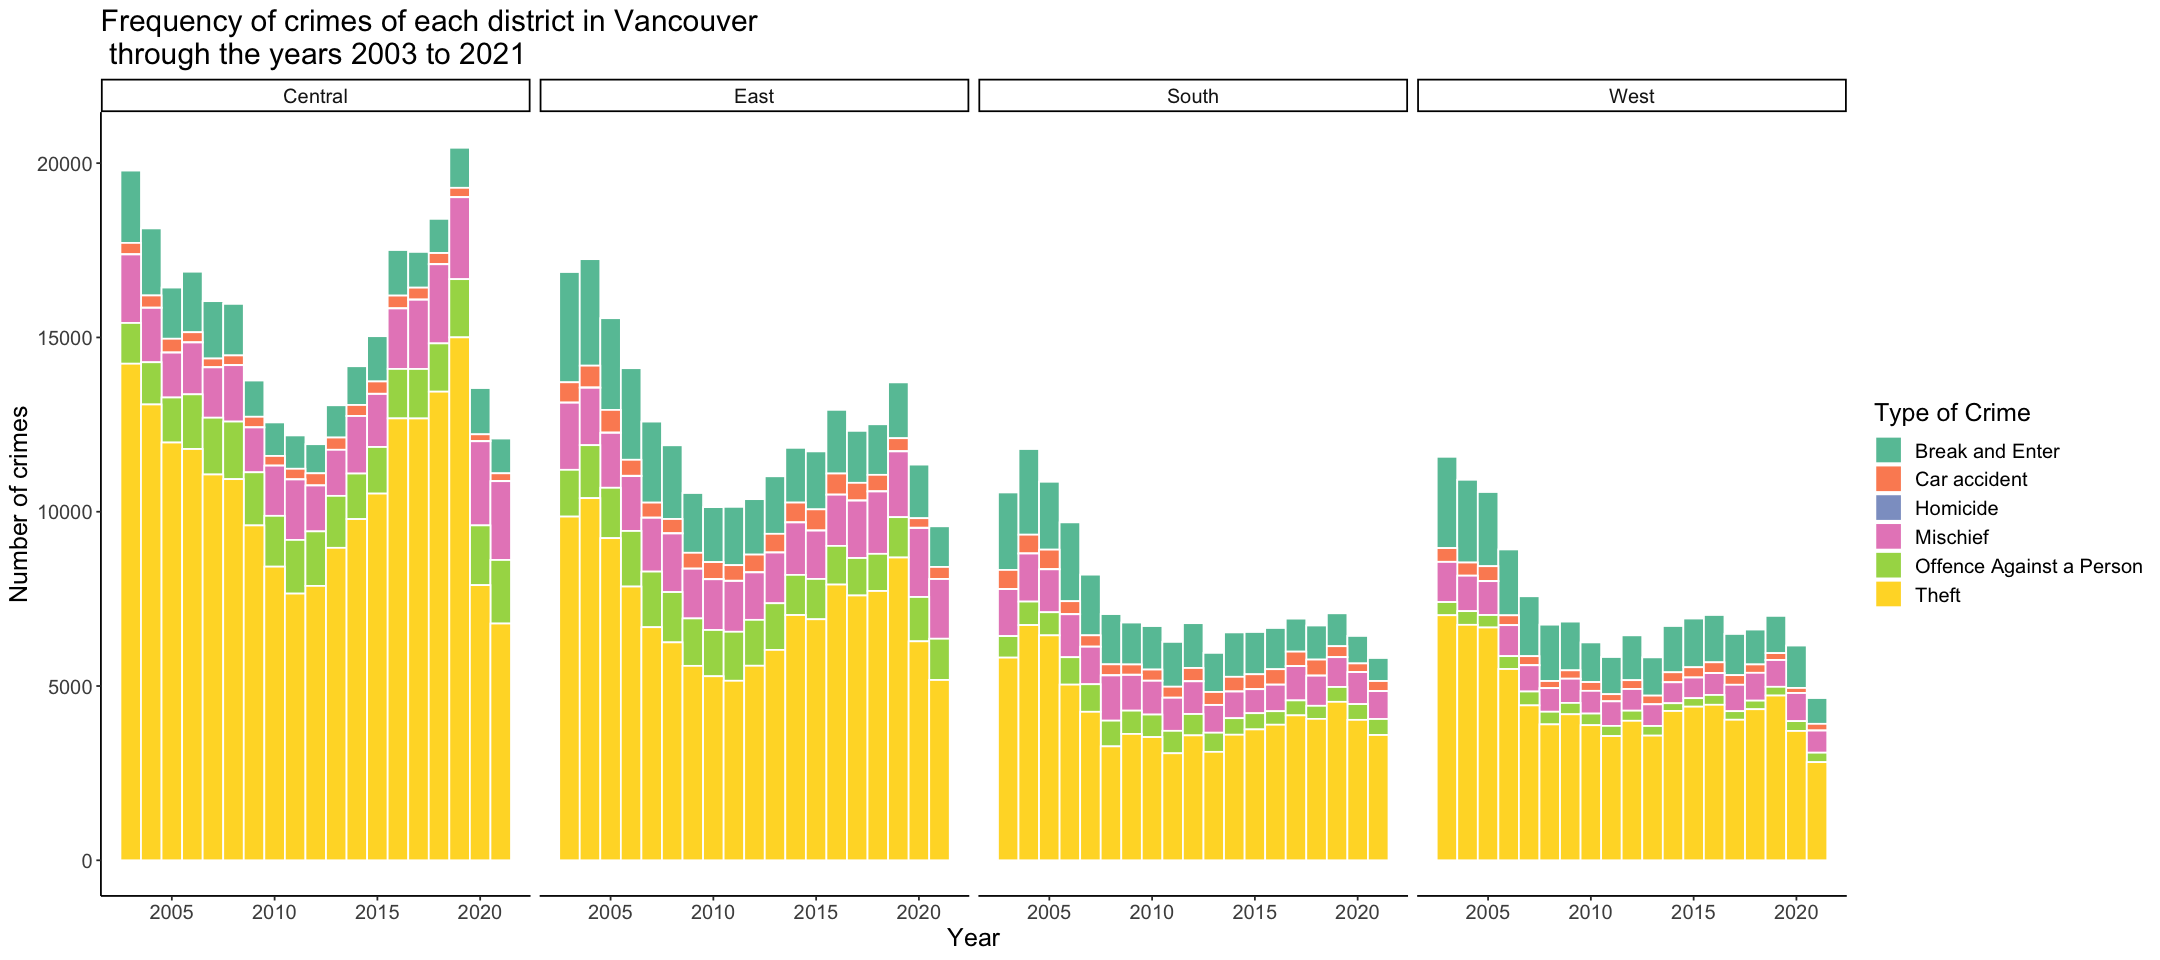

In [181]:
options(repr.plot.width = 18, repr.plot.height = 8)

years_vis <- crime_data %>%
    ggplot(aes(x = YEAR, fill = TYPE))+
    geom_histogram(binwidth = 1, color = 'white')+
    theme_classic() +
    theme(legend.position="right", 
          text = element_text(size = 15)) +
    labs(title = "Frequency of crimes of each district in Vancouver \n through the years 2003 to 2021",
         x = "Year",
         y = "Number of crimes",
         fill = "Type of Crime")+
    facet_wrap(~DISTRICT, ncol = 4)+
    scale_fill_brewer(palette = 'Set2') # colorblind friendly palette.
years_vis

#### Estimates

We are going to first need to calculate the proportion of crime that occurs in each neighborhood per year. Then we calculated the average proportion of crime that occurs in each district. 

In [183]:
# Added another column to the data which holds the proportion of crime for the corresponding district and year
# of the row.
prop_data <- crime_data %>%
    group_by(YEAR) %>%
    mutate(num_year = n()) %>%
    ungroup() %>%
    group_by(YEAR, DISTRICT) %>%
    mutate(PROP = n()/num_year) %>%
    select(-num_year)

# Using the proportion found above, find the mean over all years for each district.
estimation_table <- prop_data %>%
    group_by(DISTRICT) %>%
    summarise(MEAN_PROP = mean(PROP))

print("This table contains the average annual proportion of Vancouver crime in each district")
estimation_table

[1] "This table contains the average annual proportion of Vancouver crime in each district"


DISTRICT,MEAN_PROP
<chr>,<dbl>
Central,0.3656237
East,0.2904802
South,0.1778473
West,0.1723825


### Methods

### References


https://www150.statcan.gc.ca/n1/pub/85-002-x/2022001/article/00013-eng.htm

https://www.justice.gc.ca/eng/rp-pr/csj-sjc/crime/rr01_1/p0.html

https://www.ojp.gov/pdffiles1/nij/grants/245408.pdf

https://www.statista.com/statistics/251934/usa--percentage-of-violent-crimes-reported-to-the-police/#:~:text=In%202021%2C%20about%2045.6%20percent,to%20police%2C%20at%2060.5%20percent.

https://www.csustan.edu/sites/default/files/groups/University%20Honors%20Program/Journals_two/solorzano_yesenia_.pdf

https://www.expatarrivals.com/americas/canada/vancouver/areas-and-suburbs-vancouver